In [1]:
# 구글 드라이브 MOUNT
from google.colab import drive
drive.mount('/content/drive')

# github와 연동하고 싶은 폴더로 이동
%cd /content/drive/MyDrive/study_DL/Study_DL


Mounted at /content/drive
/content/drive/MyDrive/study_DL/Study_DL


# 파일 불러오기

## 방법1: 로컬에서 불러오기

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 2.png to 2.png
Saving 3.png to 3.png
Saving 5.png to 5.png
Saving 6.png to 6.png
Saving 8.png to 8.png
Saving 9.png to 9.png
Saving 11.png to 11.png
Saving 12.png to 12.png
Saving 14.png to 14.png
Saving 15.png to 15.png
Saving 17.png to 17.png
Saving 18.png to 18.png
Saving 20.png to 20.png
Saving 21.png to 21.png
Saving 23.png to 23.png
Saving 24.png to 24.png
Saving 26.png to 26.png
Saving 27.png to 27.png
Saving 29.png to 29.png
Saving 30.png to 30.png
Saving 32.png to 32.png
Saving 33.png to 33.png
Saving 35.png to 35.png
Saving 36.png to 36.png
Saving 38.png to 38.png
Saving 39.png to 39.png
Saving 41.png to 41.png
Saving 42.png to 42.png
Saving 44.png to 44.png
Saving 45.png to 45.png
Saving 47.png to 47.png
Saving 48.png to 48.png
Saving 50.png to 50.png
Saving 51.png to 51.png
Saving 53.png to 53.png
Saving 54.png to 54.png
Saving 56.png to 56.png
Saving 57.png to 57.png
Saving 59.png to 59.png
Saving 60.png to 60.png
Saving 62.png to 62.png
Saving 63.png to 63.png
Savi

In [ ]:
filename_li = []

for i in uploaded.keys():
  filename_li.append(i)

print(filename_li[:10])

['2.png', '3.png', '5.png', '6.png', '8.png', '9.png', '11.png', '12.png', '14.png', '15.png']


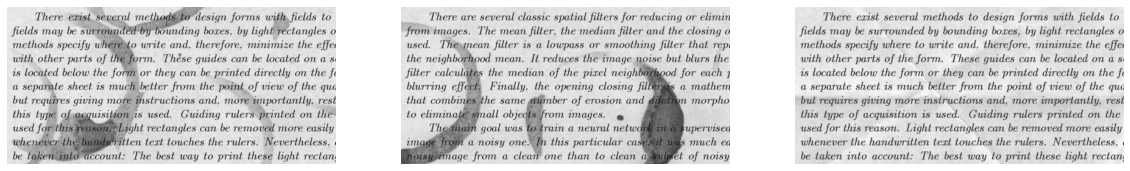

In [ ]:
plt.figure(figsize = (20, 6))

for i in range(3):
  plt.subplot(1, 3, i+1)
  img_arr = cv2.imread(filename_li[i])
  plt.imshow(img_arr)
  plt.axis('off')
plt.show()

## 방법2: google drive zipfile 형태로 불러오기

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [3]:
path_zip = '../필요데이터/kaggle_noise_text/'

In [ ]:
import zipfile

with zipfile.ZipFile(os.path.join(path_zip, 'archive.zip'), 'r') as zip_ref:
  zip_ref.extractall(path_zip)


In [4]:
train_img_path = [os.path.join(path_zip, f'train/{name}') for name in sorted(os.listdir(os.path.join(path_zip, 'train')))]
test_img_path = [os.path.join(path_zip, f'test/{name}') for name in sorted(os.listdir(os.path.join(path_zip, 'test')))]

train_cleaned_img_path = [os.path.join(path_zip, f'train_cleaned/{name}') for name in sorted(os.listdir(os.path.join(path_zip, 'train_cleaned')))]

In [5]:
len(train_img_path), len(test_img_path), len(train_cleaned_img_path)

(144, 72, 144)

# 이미지 불러오고 전처리하는 사용자함수 만들기

In [6]:
arr = cv2.imread(train_img_path[0])
arr.shape

(420, 540, 3)

In [7]:
input_shape = (420, 540, 1)

In [8]:
def process_img(path):
  img = cv2.imread(path)  #(420, 540, 3)
  img = np.asarray(img, dtype = 'float32')
  img = cv2.resize(img, (input_shape[1], input_shape[0]))  # (420, 540, 3)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # (420, 540)
  img = img/255.
  img = np.reshape(img, input_shape) # (420, 540, 1)

  return img

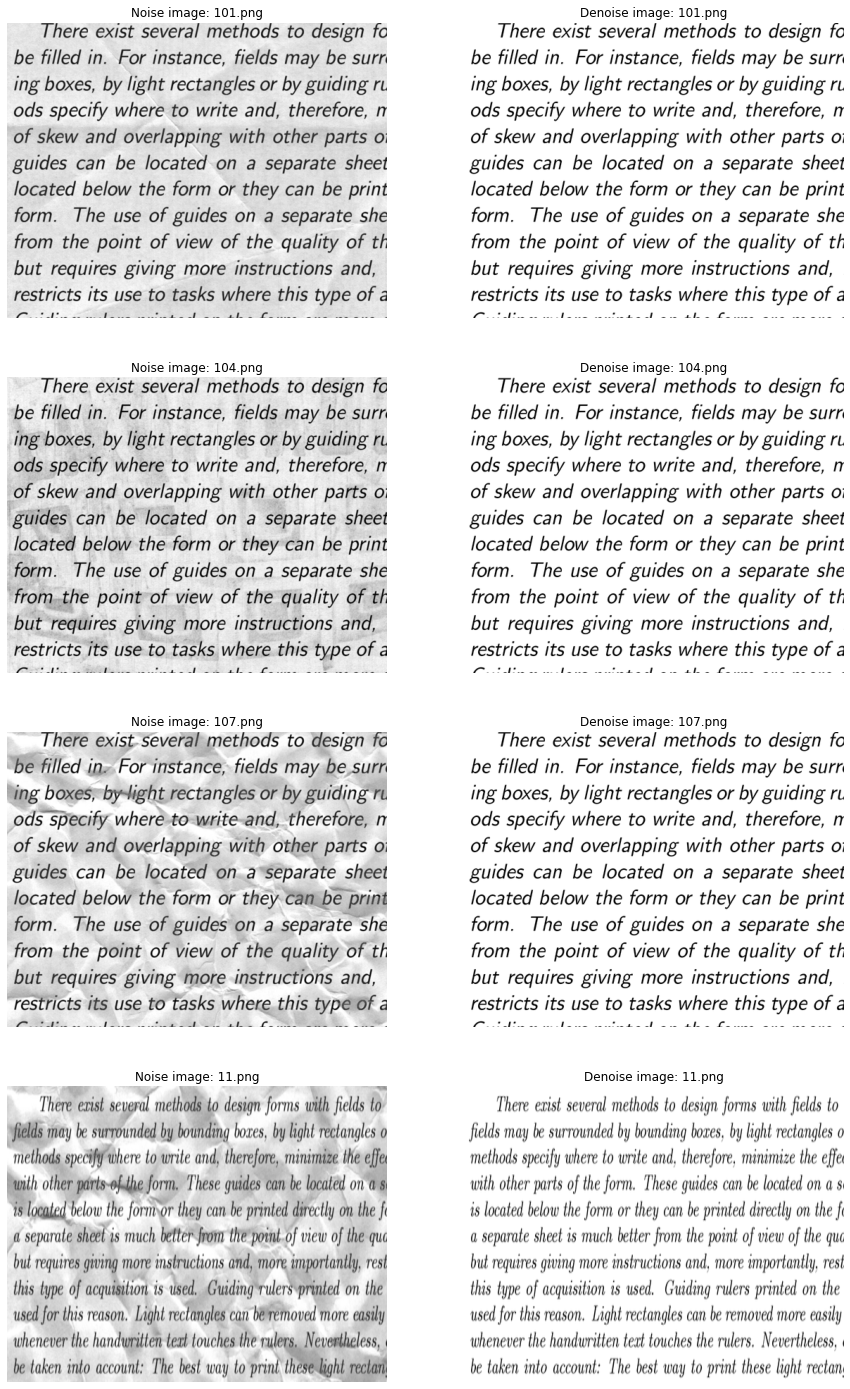

In [ ]:
plt.figure(figsize = (15,25))
for i in range(0, 8, 2):
  plt.subplot(4, 2, i + 1)
  plt.axis('off')
  plt.imshow(process_img(train_img_path[i])[:,:,0], cmap = 'gray')
  title = train_img_path[i].split('train/')[1]
  plt.title(f'Noise image: {title}')

  plt.subplot(4, 2, i + 2)
  plt.axis('off')
  plt.imshow(process_img(train_cleaned_img_path[i])[:,:,0], cmap = 'gray')
  title = train_cleaned_img_path[i].split('train_cleaned/')[1]
  plt.title(f'Denoise image: {title}')


In [9]:
train = [process_img(path) for path in train_img_path]
train_cleaned = [process_img(path) for path in train_cleaned_img_path]
test = [process_img(path) for path in test_img_path]

# 훈련/검증/테스트 데이터 나누기

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_tr = np.asarray(train)
y_tr = np.asarray(train_cleaned)
x_test = np.asarray(test)

x_train, x_val, y_train, y_val = train_test_split(x_tr, y_tr, test_size = 0.1)

In [12]:
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [
    {'filters': 64, 'kernel_size':3},
    {'filters': 128, 'kernel_size':3},
    {'filters': 256, 'kernel_size':3},
]

In [13]:
from keras import backend as K
from keras.layers import *
from tensorflow.keras.models import Model

In [16]:
def model():
  input_layer = Input(shape = input_shape)

  # 인코딩
  x = input_layer
  for layer_f in layer_filters:
    x = Conv2D(layer_f['filters'], layer_f['kernel_size'], 
               activation = 'relu', padding = 'same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D(2, padding = 'same')(x)
  x = Dropout(0.5)(x)

  # 디코딩
  for layer_f in layer_filters[::-1]:
    x = Conv2D(layer_f['filters'], layer_f['kernel_size'], 
               activation = 'relu', padding = 'same')(x)

  x = BatchNormalization()(x)
  x = UpSampling2D(2)(x)

  output_layer = Conv2D(1, 3, activation = 'sigmoid', padding = 'same')(x)

  autoencoder = Model(input_layer, output_layer)
  autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])
  return autoencoder

In [17]:
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 420, 540, 256)     295168    
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 256)    1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 256)    0         
 )                                                           

In [18]:
model_weights_file_path = './save_model/savebest_model_weights.hdf5'

In [20]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath = 'model_weights_file_path',
                             monitor = 'val_loss',
                             mode = 'min',
                             verbose = 1,
                             save_best_only = True)

earlystop = EarlyStopping(monitor = 'val_loss',
                          mode = 'min',
                          verbose = 1,
                          patience = 30)

lr_reduce = ReduceLROnPlateau(monitor = 'val_loss',
                              mode = 'min',
                              factor = 0.5,
                              patience = 20,
                              verbose = 0,
                              min_delta = 0.0001,
                              cooldown = 0,
                              min_lr = 0)


In [21]:
callbacks = [checkpoint, earlystop, lr_reduce]
epochs = 500
batch_size = 8

In [ ]:
history = model.fit(x_train, y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1,
                    callbacks = callbacks,
                    validation_data = (x_val, y_val))

Epoch 1/500
 9/17 [==============>...............] - ETA: 15s - loss: 0.1556 - mae: 0.2968